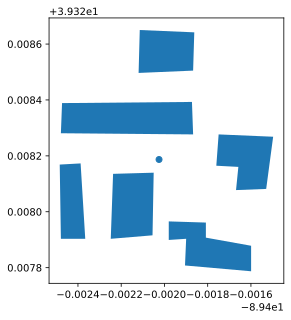

In [8]:
import numpy as np
import pandas as pd
import time
import h5pyd
import geopandas as gpd
import matplotlib.pyplot as plt
from shapely import geometry
import os

from dw_tap.process_geojson import get_obstacles
from dw_tap.data_fetching import getData
from dw_tap.process_geojson import get_candidate
from dw_tap.lom import run_lom
from dw_tap.power_output import estimate_power_output

%config InlineBackend.figure_format = 'svg'

df_places = get_obstacles("../sites/map-180.geojson")

ax=df_places.geometry.plot()

# Need to use better projection
# source of solution: https://gis.stackexchange.com/questions/372564/userwarning-when-trying-to-get-centroid-from-a-polygon-geopandas
df_places_centroid = df_places.dissolve().to_crs('+proj=cea').centroid.to_crs(df_places.crs)
df_places_centroid.geometry.plot(ax=ax);

In [2]:
# Creating the grid over site

# Here using 1 degree = 111,000m -- 
# This crude approx should be an appropriate option for point generation
m_per_deg = 111000

site_box_width_m = 1000
site_box_height_m = 1000

# halfs of box / dimensions
lon_delta = (site_box_width_m / m_per_deg ) / 2.0
lat_delta = (site_box_height_m / m_per_deg ) / 2.0

df_places_centroid.geometry.x, df_places_centroid.geometry.y
#print(lon_delta, lat_delta)

lon_n, lat_n = (10, 10)
x = np.linspace(df_places_centroid.geometry.x-lon_delta, 
                df_places_centroid.geometry.x+lon_delta, 
                lon_n)
y = np.linspace(df_places_centroid.geometry.y-lat_delta, 
                df_places_centroid.geometry.y+lat_delta, 
                lat_n)
xv, yv = np.meshgrid(x, y)
#xv, yv

/var/folders/j_/dq5lhppd2jlb45qt4fw_cqth59pwpf/T/ipykernel_80586/1429394866.py:13: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: None
Right CRS: EPSG:4326

  inside_polygons_index = gpd.sjoin(gridpoints, df_places, op='within').index


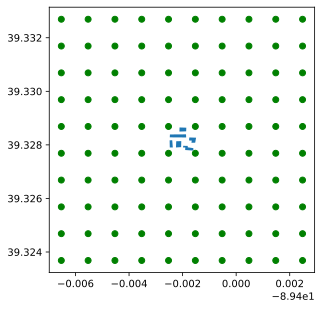

In [3]:
# plotting using two arrays, xv and yv, created by meshgrid()
# Probably not the best format for exluding points that fall inside the buildings 

#ax=df_places.geometry.plot()
#df_places_centroid.geometry.plot(ax=ax);
#ax.plot(xv, yv, ls="None", marker=".");
#plt.show()

gridpoints = gpd.GeoDataFrame(
    {"geometry": [geometry.Point(el) for el in zip(xv.flatten(), yv.flatten())]})
#gridpoints.plot();

inside_polygons_index = gpd.sjoin(gridpoints, df_places, op='within').index
outside_polygons_index = [i for i in gridpoints.index if i not in inside_polygons_index]
gridpoints_outside_polygons = gridpoints.loc[outside_polygons_index]

ax=df_places.geometry.plot()
#df_places_centroid.geometry.plot(ax=ax);

#ax.plot(xv, yv, ls="None", marker=".");
gridpoints_outside_polygons.plot(color="green", ax=ax)
plt.show()

In [4]:
gridpoints_outside_polygons

,geometry
0,POINT (-89.40653 39.32368)
1,POINT (-89.40553 39.32368)
2,POINT (-89.40453 39.32368)
3,POINT (-89.40353 39.32368)
4,POINT (-89.40253 39.32368)
...,...
95,POINT (-89.40152 39.33269)
96,POINT (-89.40052 39.33269)
97,POINT (-89.39952 39.33269)
98,POINT (-89.39852 39.33269)


In [5]:
# Open the wind data "file"
# server endpoint, username, password is found via a config file
f = h5pyd.File("/nrel/wtk-us.h5", 'r', bucket="nrel-pds-hsds") 

# quick test of HSDS
# z_turbine = 40
# x = getData(f, 
#             39.32856, 
#             -89.40238, 
#             z_turbine, "IDW", True, 
#             0, 2000, 200)
# x

In [7]:
8760/2.0

4380.0

In [42]:
# New way of creating a summary dataframe, one quantity at a time; NO LOM

# Replace old files or not
overwrite = False

z_turbine = 40   
obstacles_df = df_places   

output_dest = "../output/heatmap-180/"
if not os.path.exists(output_dest):
    os.makedirs(output_dest)

gridpoints_outside_polygons["ws"] = None
gridpoints_outside_polygons["wd"] = None

summary_df_cols = ["geometry", "time_period", 
                   "khw_without_lom", "khw_with_lom", "kwh_delta", 
                   "ts_file_path"]
summary_df = pd.DataFrame(columns=summary_df_cols)
summary_df_path = os.path.join(output_dest, "summary.csv")

if os.path.exists(summary_df_path):
    summary_df = pd.read_csv(summary_df_path)

for idx in gridpoints_outside_polygons.index:
    lat, lon = gridpoints_outside_polygons.at[idx, "geometry"].y, gridpoints_outside_polygons.at[idx, "geometry"].x
    print("Estimating for: (%.3f, %.3f)" % (lat, lon))
    
    lat_lon_label = str(lat) + "_" + str(lon)
    #print(lat_lon_label)
    
    ts_df_path = os.path.join(output_dest, lat_lon_label + ".csv")
    #print(ts_df_path)
    
    if os.path.exists(ts_df_path) and (not overwrite):
        print("This point was already processed. Skipping to the next one (overwrite flag is off)")
        continue

    atmospheric_df = getData(f, 
                             lat, 
                             lon, 
                             z_turbine, "IDW", True, 
                             0, 4380, 1) # 0, 4380, 1) # year: 8760; Quick test: 0, 2000, 200)
    
    time_period = str(atmospheric_df["datetime"][0]) + " - " + str(atmospheric_df["datetime"][len(atmospheric_df)-1])
    
    #gridpoints_outside_polygons.at[idx, "ws"] = ws.tolist()
    #gridpoints_outside_polygons.at[idx, "wd"] = theta.tolist()
    
    x1_turbine,y1_turbine,minx,maxx,miny,maxy = get_candidate(lat, lon)
    xy_turbine = [np.array([x1_turbine, y1_turbine])]
    
    predictions_df = \
        run_lom(atmospheric_df, obstacles_df, xy_turbine, z_turbine)
    
    time_powerOutput0 = time.time()

    kw_ts_with_lom, above_curve, below_curve, above_curve_list, below_curve_list = \
        estimate_power_output(predictions_df, atmospheric_df['temp'], atmospheric_df['pres'],
                              ws_column="ws-adjusted")  
    kwh_total_with_lom = kw_ts_with_lom.sum()
    
    kw_ts_without_lom, above_curve, below_curve, above_curve_list, below_curve_list = \
        estimate_power_output(predictions_df, atmospheric_df['temp'], atmospheric_df['pres'],
                              ws_column="ws")  
    kwh_total_without_lom = kw_ts_without_lom.sum()
    
    print("Total kWh (with and without LOM):", kwh_total_with_lom, kwh_total_without_lom)
    
    #for t, ws_v, wd_v, kw_v in zip(dates, ws, theta, kw):
    #    gridpoints_df.loc[len(gridpoints_df)] = [gridpoints_outside_polygons.at[idx, "geometry"], t, "windspeed", ws_v]
    #    gridpoints_df.loc[len(gridpoints_df)] = [gridpoints_outside_polygons.at[idx, "geometry"], t, "winddirection", wd_v]
    #    gridpoints_df.loc[len(gridpoints_df)] = [gridpoints_outside_polygons.at[idx, "geometry"], t, "kw", kw_v]  
    
    #gridpoints_df.loc[len(gridpoints_df)] = [gridpoints_outside_polygons.at[idx, "geometry"], "Total", "kwh_total_without_lom", kw_total_without_lom]
    #gridpoints_df.loc[len(gridpoints_df)] = [gridpoints_outside_polygons.at[idx, "geometry"], "Total", "kwh_total_with_lom", kw_total_with_lom]
    #gridpoints_df.loc[len(gridpoints_df)] = [gridpoints_outside_polygons.at[idx, "geometry"], "Total", "kwh_diff", kw_total_without_lom - kw_total_with_lom]
    
    summary_df.loc[len(summary_df)] = [gridpoints_outside_polygons.at[idx, "geometry"],
                                       time_period,
                                       kwh_total_without_lom,
                                       kwh_total_with_lom,
                                       kwh_total_without_lom - kwh_total_with_lom,
                                       ts_df_path]
    
    ts_df = pd.DataFrame({"datetime": atmospheric_df["datetime"],
                          "ws": atmospheric_df["ws"],
                          "wd": atmospheric_df["wd"],
                          "ws-adjusted": predictions_df["ws-adjusted"],
                          "kw_ts_without_lom": kw_ts_without_lom,
                          "kw_ts_with_lom": kw_ts_with_lom})
    
    summary_df.to_csv(summary_df_path, index=False)
    ts_df.to_csv(ts_df_path, index=False)
                                           
    #break

#gridpoints_df

Estimating for: (39.324, -89.407)
This point was already processed. Skipping to the next one (overwrite flag is off)
Estimating for: (39.324, -89.406)
This point was already processed. Skipping to the next one (overwrite flag is off)
Estimating for: (39.324, -89.405)
This point was already processed. Skipping to the next one (overwrite flag is off)
Estimating for: (39.324, -89.404)
This point was already processed. Skipping to the next one (overwrite flag is off)
Estimating for: (39.324, -89.403)
This point was already processed. Skipping to the next one (overwrite flag is off)
Estimating for: (39.324, -89.402)
This point was already processed. Skipping to the next one (overwrite flag is off)
Estimating for: (39.324, -89.401)
This point was already processed. Skipping to the next one (overwrite flag is off)
Estimating for: (39.324, -89.400)
This point was already processed. Skipping to the next one (overwrite flag is off)
Estimating for: (39.324, -89.399)
This point was already process

/Users/dduplyak/anaconda3/envs/dw-tap/lib/python3.8/site-packages/pandas/core/dtypes/cast.py:122: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  arr = construct_1d_object_array_from_listlike(values)


run_lom: starting
run_lom: loaded model
run_lom: after geojson_toCoordinate
run_lom: after prepare_data
run_lom: looping
LOM time : 1.89  min
Total kWh (with and without LOM): 8416.01069502564 9128.167528883416
Estimating for: (39.329, -89.399)


/Users/dduplyak/anaconda3/envs/dw-tap/lib/python3.8/site-packages/pandas/core/dtypes/cast.py:122: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  arr = construct_1d_object_array_from_listlike(values)


run_lom: starting
run_lom: loaded model
run_lom: after geojson_toCoordinate
run_lom: after prepare_data
run_lom: looping
LOM time : 1.89  min
Total kWh (with and without LOM): 8847.93181650032 9124.984167126495
Estimating for: (39.329, -89.398)


/Users/dduplyak/anaconda3/envs/dw-tap/lib/python3.8/site-packages/pandas/core/dtypes/cast.py:122: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  arr = construct_1d_object_array_from_listlike(values)


run_lom: starting
run_lom: loaded model
run_lom: after geojson_toCoordinate
run_lom: after prepare_data
run_lom: looping
LOM time : 1.83  min
Total kWh (with and without LOM): 8993.750283859124 9122.0270933313
Estimating for: (39.330, -89.407)


/Users/dduplyak/anaconda3/envs/dw-tap/lib/python3.8/site-packages/pandas/core/dtypes/cast.py:122: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  arr = construct_1d_object_array_from_listlike(values)


run_lom: starting
run_lom: loaded model
run_lom: after geojson_toCoordinate
run_lom: after prepare_data
run_lom: looping
LOM time : 1.32  min
Total kWh (with and without LOM): 9038.255104248421 9043.411346067864
Estimating for: (39.330, -89.406)


/Users/dduplyak/anaconda3/envs/dw-tap/lib/python3.8/site-packages/pandas/core/dtypes/cast.py:122: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  arr = construct_1d_object_array_from_listlike(values)


run_lom: starting
run_lom: loaded model
run_lom: after geojson_toCoordinate
run_lom: after prepare_data
run_lom: looping
LOM time : 1.36  min
Total kWh (with and without LOM): 9042.083597316156 9047.998057435041
Estimating for: (39.330, -89.405)


/Users/dduplyak/anaconda3/envs/dw-tap/lib/python3.8/site-packages/pandas/core/dtypes/cast.py:122: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  arr = construct_1d_object_array_from_listlike(values)


run_lom: starting
run_lom: loaded model
run_lom: after geojson_toCoordinate
run_lom: after prepare_data
run_lom: looping
LOM time : 1.41  min
Total kWh (with and without LOM): 9045.255388480986 9051.20986046083
Estimating for: (39.330, -89.404)


/Users/dduplyak/anaconda3/envs/dw-tap/lib/python3.8/site-packages/pandas/core/dtypes/cast.py:122: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  arr = construct_1d_object_array_from_listlike(values)


run_lom: starting
run_lom: loaded model
run_lom: after geojson_toCoordinate
run_lom: after prepare_data
run_lom: looping
LOM time : 1.48  min
Total kWh (with and without LOM): 9049.373164567309 9052.906351275478
Estimating for: (39.330, -89.403)


/Users/dduplyak/anaconda3/envs/dw-tap/lib/python3.8/site-packages/pandas/core/dtypes/cast.py:122: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  arr = construct_1d_object_array_from_listlike(values)


run_lom: starting
run_lom: loaded model
run_lom: after geojson_toCoordinate
run_lom: after prepare_data
run_lom: looping
LOM time : 1.58  min
Total kWh (with and without LOM): 9105.27187610756 9124.477844091449
Estimating for: (39.330, -89.402)


/Users/dduplyak/anaconda3/envs/dw-tap/lib/python3.8/site-packages/pandas/core/dtypes/cast.py:122: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  arr = construct_1d_object_array_from_listlike(values)


run_lom: starting
run_lom: loaded model
run_lom: after geojson_toCoordinate
run_lom: after prepare_data
run_lom: looping
LOM time : 1.66  min
Total kWh (with and without LOM): 8993.483725987164 9122.777431778082
Estimating for: (39.330, -89.401)


/Users/dduplyak/anaconda3/envs/dw-tap/lib/python3.8/site-packages/pandas/core/dtypes/cast.py:122: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  arr = construct_1d_object_array_from_listlike(values)


run_lom: starting
run_lom: loaded model
run_lom: after geojson_toCoordinate
run_lom: after prepare_data
run_lom: looping
LOM time : 1.83  min
Total kWh (with and without LOM): 8371.680549870849 9120.66361363201
Estimating for: (39.330, -89.400)


/Users/dduplyak/anaconda3/envs/dw-tap/lib/python3.8/site-packages/pandas/core/dtypes/cast.py:122: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  arr = construct_1d_object_array_from_listlike(values)


run_lom: starting
run_lom: loaded model
run_lom: after geojson_toCoordinate
run_lom: after prepare_data
run_lom: looping
LOM time : 1.77  min
Total kWh (with and without LOM): 7696.106209368978 9118.365090753166
Estimating for: (39.330, -89.399)


/Users/dduplyak/anaconda3/envs/dw-tap/lib/python3.8/site-packages/pandas/core/dtypes/cast.py:122: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  arr = construct_1d_object_array_from_listlike(values)


run_lom: starting
run_lom: loaded model
run_lom: after geojson_toCoordinate
run_lom: after prepare_data
run_lom: looping
LOM time : 1.8  min
Total kWh (with and without LOM): 7291.329266385684 9116.039034944715
Estimating for: (39.330, -89.398)


/Users/dduplyak/anaconda3/envs/dw-tap/lib/python3.8/site-packages/pandas/core/dtypes/cast.py:122: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  arr = construct_1d_object_array_from_listlike(values)


run_lom: starting
run_lom: loaded model
run_lom: after geojson_toCoordinate
run_lom: after prepare_data
run_lom: looping
LOM time : 1.85  min
Total kWh (with and without LOM): 7754.316126124339 9113.857538276217
Estimating for: (39.331, -89.407)


/Users/dduplyak/anaconda3/envs/dw-tap/lib/python3.8/site-packages/pandas/core/dtypes/cast.py:122: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  arr = construct_1d_object_array_from_listlike(values)


run_lom: starting
run_lom: loaded model
run_lom: after geojson_toCoordinate
run_lom: after prepare_data
run_lom: looping
LOM time : 1.44  min
Total kWh (with and without LOM): 9026.631009341285 9028.601707816248
Estimating for: (39.331, -89.406)


/Users/dduplyak/anaconda3/envs/dw-tap/lib/python3.8/site-packages/pandas/core/dtypes/cast.py:122: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  arr = construct_1d_object_array_from_listlike(values)


run_lom: starting
run_lom: loaded model
run_lom: after geojson_toCoordinate
run_lom: after prepare_data
run_lom: looping
LOM time : 1.44  min
Total kWh (with and without LOM): 9030.678944305819 9032.325890841246
Estimating for: (39.331, -89.405)


/Users/dduplyak/anaconda3/envs/dw-tap/lib/python3.8/site-packages/pandas/core/dtypes/cast.py:122: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  arr = construct_1d_object_array_from_listlike(values)


run_lom: starting
run_lom: loaded model
run_lom: after geojson_toCoordinate
run_lom: after prepare_data
run_lom: looping
LOM time : 1.48  min
Total kWh (with and without LOM): 9034.283731756459 9035.058426370377
Estimating for: (39.331, -89.404)


/Users/dduplyak/anaconda3/envs/dw-tap/lib/python3.8/site-packages/pandas/core/dtypes/cast.py:122: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  arr = construct_1d_object_array_from_listlike(values)


run_lom: starting
run_lom: loaded model
run_lom: after geojson_toCoordinate
run_lom: after prepare_data
run_lom: looping
LOM time : 1.53  min
Total kWh (with and without LOM): 9034.154875138054 9036.730761059498
Estimating for: (39.331, -89.403)


/Users/dduplyak/anaconda3/envs/dw-tap/lib/python3.8/site-packages/pandas/core/dtypes/cast.py:122: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  arr = construct_1d_object_array_from_listlike(values)


run_lom: starting
run_lom: loaded model
run_lom: after geojson_toCoordinate
run_lom: after prepare_data
run_lom: looping
LOM time : 1.59  min
Total kWh (with and without LOM): 9103.240517132519 9112.889821404879
Estimating for: (39.331, -89.402)


/Users/dduplyak/anaconda3/envs/dw-tap/lib/python3.8/site-packages/pandas/core/dtypes/cast.py:122: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  arr = construct_1d_object_array_from_listlike(values)


run_lom: starting
run_lom: loaded model
run_lom: after geojson_toCoordinate
run_lom: after prepare_data
run_lom: looping
LOM time : 1.73  min
Total kWh (with and without LOM): 9081.618504245827 9111.666567084834
Estimating for: (39.331, -89.401)


/Users/dduplyak/anaconda3/envs/dw-tap/lib/python3.8/site-packages/pandas/core/dtypes/cast.py:122: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  arr = construct_1d_object_array_from_listlike(values)


run_lom: starting
run_lom: loaded model
run_lom: after geojson_toCoordinate
run_lom: after prepare_data
run_lom: looping
LOM time : 1.72  min
Total kWh (with and without LOM): 9015.938358953978 9110.188796943326
Estimating for: (39.331, -89.400)


/Users/dduplyak/anaconda3/envs/dw-tap/lib/python3.8/site-packages/pandas/core/dtypes/cast.py:122: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  arr = construct_1d_object_array_from_listlike(values)


run_lom: starting
run_lom: loaded model
run_lom: after geojson_toCoordinate
run_lom: after prepare_data
run_lom: looping
LOM time : 1.9  min
Total kWh (with and without LOM): 8753.24770104423 9108.580797162289
Estimating for: (39.331, -89.399)


/Users/dduplyak/anaconda3/envs/dw-tap/lib/python3.8/site-packages/pandas/core/dtypes/cast.py:122: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  arr = construct_1d_object_array_from_listlike(values)


run_lom: starting
run_lom: loaded model
run_lom: after geojson_toCoordinate
run_lom: after prepare_data
run_lom: looping
LOM time : 1.94  min
Total kWh (with and without LOM): 7588.9210122154145 9106.96837451207
Estimating for: (39.331, -89.398)


/Users/dduplyak/anaconda3/envs/dw-tap/lib/python3.8/site-packages/pandas/core/dtypes/cast.py:122: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  arr = construct_1d_object_array_from_listlike(values)


run_lom: starting
run_lom: loaded model
run_lom: after geojson_toCoordinate
run_lom: after prepare_data
run_lom: looping
LOM time : 1.86  min
Total kWh (with and without LOM): 6764.608577340843 9105.44720000623
Estimating for: (39.332, -89.407)


/Users/dduplyak/anaconda3/envs/dw-tap/lib/python3.8/site-packages/pandas/core/dtypes/cast.py:122: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  arr = construct_1d_object_array_from_listlike(values)


run_lom: starting
run_lom: loaded model
run_lom: after geojson_toCoordinate
run_lom: after prepare_data
run_lom: looping
LOM time : 1.46  min
Total kWh (with and without LOM): 9014.980238544505 9015.668189483971
Estimating for: (39.332, -89.406)


/Users/dduplyak/anaconda3/envs/dw-tap/lib/python3.8/site-packages/pandas/core/dtypes/cast.py:122: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  arr = construct_1d_object_array_from_listlike(values)


run_lom: starting
run_lom: loaded model
run_lom: after geojson_toCoordinate
run_lom: after prepare_data
run_lom: looping
LOM time : 1.49  min
Total kWh (with and without LOM): 9018.471281506367 9018.78014692271
Estimating for: (39.332, -89.405)


/Users/dduplyak/anaconda3/envs/dw-tap/lib/python3.8/site-packages/pandas/core/dtypes/cast.py:122: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  arr = construct_1d_object_array_from_listlike(values)


run_lom: starting
run_lom: loaded model
run_lom: after geojson_toCoordinate
run_lom: after prepare_data
run_lom: looping
LOM time : 1.6  min
Total kWh (with and without LOM): 9020.46375859683 9021.164229686383
Estimating for: (39.332, -89.404)


/Users/dduplyak/anaconda3/envs/dw-tap/lib/python3.8/site-packages/pandas/core/dtypes/cast.py:122: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  arr = construct_1d_object_array_from_listlike(values)


run_lom: starting
run_lom: loaded model
run_lom: after geojson_toCoordinate
run_lom: after prepare_data
run_lom: looping
LOM time : 1.64  min
Total kWh (with and without LOM): 9020.338657946813 9022.787925509634
Estimating for: (39.332, -89.403)


/Users/dduplyak/anaconda3/envs/dw-tap/lib/python3.8/site-packages/pandas/core/dtypes/cast.py:122: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  arr = construct_1d_object_array_from_listlike(values)


run_lom: starting
run_lom: loaded model
run_lom: after geojson_toCoordinate
run_lom: after prepare_data
run_lom: looping
LOM time : 1.72  min
Total kWh (with and without LOM): 9096.274105348662 9101.851213222388
Estimating for: (39.332, -89.402)


/Users/dduplyak/anaconda3/envs/dw-tap/lib/python3.8/site-packages/pandas/core/dtypes/cast.py:122: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  arr = construct_1d_object_array_from_listlike(values)


run_lom: starting
run_lom: loaded model
run_lom: after geojson_toCoordinate
run_lom: after prepare_data
run_lom: looping
LOM time : 1.66  min
Total kWh (with and without LOM): 9088.531070256984 9100.94993418156
Estimating for: (39.332, -89.401)


/Users/dduplyak/anaconda3/envs/dw-tap/lib/python3.8/site-packages/pandas/core/dtypes/cast.py:122: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  arr = construct_1d_object_array_from_listlike(values)


run_lom: starting
run_lom: loaded model
run_lom: after geojson_toCoordinate
run_lom: after prepare_data
run_lom: looping
LOM time : 1.73  min
Total kWh (with and without LOM): 9072.485134045066 9099.934489791112
Estimating for: (39.332, -89.400)


/Users/dduplyak/anaconda3/envs/dw-tap/lib/python3.8/site-packages/pandas/core/dtypes/cast.py:122: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  arr = construct_1d_object_array_from_listlike(values)


run_lom: starting
run_lom: loaded model
run_lom: after geojson_toCoordinate
run_lom: after prepare_data
run_lom: looping
LOM time : 1.71  min
Total kWh (with and without LOM): 9033.963000910973 9098.873171141982


/Users/dduplyak/anaconda3/envs/dw-tap/lib/python3.8/site-packages/pandas/core/dtypes/cast.py:122: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  arr = construct_1d_object_array_from_listlike(values)


Estimating for: (39.332, -89.399)
run_lom: starting
run_lom: loaded model
run_lom: after geojson_toCoordinate
run_lom: after prepare_data
run_lom: looping
LOM time : 1.81  min
Total kWh (with and without LOM): 8925.263000544704 9097.836620468224
Estimating for: (39.332, -89.398)


/Users/dduplyak/anaconda3/envs/dw-tap/lib/python3.8/site-packages/pandas/core/dtypes/cast.py:122: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  arr = construct_1d_object_array_from_listlike(values)


run_lom: starting
run_lom: loaded model
run_lom: after geojson_toCoordinate
run_lom: after prepare_data
run_lom: looping
LOM time : 1.84  min
Total kWh (with and without LOM): 8529.890285167909 9096.87969414116
Estimating for: (39.333, -89.407)


/Users/dduplyak/anaconda3/envs/dw-tap/lib/python3.8/site-packages/pandas/core/dtypes/cast.py:122: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  arr = construct_1d_object_array_from_listlike(values)


run_lom: starting
run_lom: loaded model
run_lom: after geojson_toCoordinate
run_lom: after prepare_data
run_lom: looping
LOM time : 1.49  min
Total kWh (with and without LOM): 9004.154003030231 9004.314834558907
Estimating for: (39.333, -89.406)


/Users/dduplyak/anaconda3/envs/dw-tap/lib/python3.8/site-packages/pandas/core/dtypes/cast.py:122: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  arr = construct_1d_object_array_from_listlike(values)


run_lom: starting
run_lom: loaded model
run_lom: after geojson_toCoordinate
run_lom: after prepare_data
run_lom: looping
LOM time : 1.52  min
Total kWh (with and without LOM): 9006.710198806735 9006.979548673295
Estimating for: (39.333, -89.405)


/Users/dduplyak/anaconda3/envs/dw-tap/lib/python3.8/site-packages/pandas/core/dtypes/cast.py:122: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  arr = construct_1d_object_array_from_listlike(values)


run_lom: starting
run_lom: loaded model
run_lom: after geojson_toCoordinate
run_lom: after prepare_data
run_lom: looping
LOM time : 1.58  min
Total kWh (with and without LOM): 9008.19730711299 9009.097957959704
Estimating for: (39.333, -89.404)


/Users/dduplyak/anaconda3/envs/dw-tap/lib/python3.8/site-packages/pandas/core/dtypes/cast.py:122: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  arr = construct_1d_object_array_from_listlike(values)


run_lom: starting
run_lom: loaded model
run_lom: after geojson_toCoordinate
run_lom: after prepare_data
run_lom: looping
LOM time : 1.58  min
Total kWh (with and without LOM): 9008.665614550202 9010.662676090851
Estimating for: (39.333, -89.403)


/Users/dduplyak/anaconda3/envs/dw-tap/lib/python3.8/site-packages/pandas/core/dtypes/cast.py:122: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  arr = construct_1d_object_array_from_listlike(values)


run_lom: starting
run_lom: loaded model
run_lom: after geojson_toCoordinate
run_lom: after prepare_data
run_lom: looping
LOM time : 1.62  min
Total kWh (with and without LOM): 9087.509837261927 9091.124297417577
Estimating for: (39.333, -89.402)


/Users/dduplyak/anaconda3/envs/dw-tap/lib/python3.8/site-packages/pandas/core/dtypes/cast.py:122: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  arr = construct_1d_object_array_from_listlike(values)


run_lom: starting
run_lom: loaded model
run_lom: after geojson_toCoordinate
run_lom: after prepare_data
run_lom: looping
LOM time : 1.64  min
Total kWh (with and without LOM): 9083.761421499275 9090.465671236085
Estimating for: (39.333, -89.401)


/Users/dduplyak/anaconda3/envs/dw-tap/lib/python3.8/site-packages/pandas/core/dtypes/cast.py:122: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  arr = construct_1d_object_array_from_listlike(values)


run_lom: starting
run_lom: loaded model
run_lom: after geojson_toCoordinate
run_lom: after prepare_data
run_lom: looping
LOM time : 1.64  min
Total kWh (with and without LOM): 9077.45283440438 9089.812921020484
Estimating for: (39.333, -89.400)


/Users/dduplyak/anaconda3/envs/dw-tap/lib/python3.8/site-packages/pandas/core/dtypes/cast.py:122: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  arr = construct_1d_object_array_from_listlike(values)


run_lom: starting
run_lom: loaded model
run_lom: after geojson_toCoordinate
run_lom: after prepare_data
run_lom: looping
LOM time : 1.63  min
Total kWh (with and without LOM): 9066.187295693557 9089.205065271037
Estimating for: (39.333, -89.399)


/Users/dduplyak/anaconda3/envs/dw-tap/lib/python3.8/site-packages/pandas/core/dtypes/cast.py:122: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  arr = construct_1d_object_array_from_listlike(values)


run_lom: starting
run_lom: loaded model
run_lom: after geojson_toCoordinate
run_lom: after prepare_data
run_lom: looping
LOM time : 1.67  min
Total kWh (with and without LOM): 9042.503592093479 9088.673427739632
Estimating for: (39.333, -89.398)


/Users/dduplyak/anaconda3/envs/dw-tap/lib/python3.8/site-packages/pandas/core/dtypes/cast.py:122: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  arr = construct_1d_object_array_from_listlike(values)


run_lom: starting
run_lom: loaded model
run_lom: after geojson_toCoordinate
run_lom: after prepare_data
run_lom: looping
LOM time : 1.7  min
Total kWh (with and without LOM): 8988.319001538432 9088.235576814239


/Users/dduplyak/anaconda3/envs/dw-tap/lib/python3.8/site-packages/pandas/core/dtypes/cast.py:122: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  arr = construct_1d_object_array_from_listlike(values)


In [37]:
atmospheric_df

,datetime,ws,wd,temp,pres
0,2007-01-01 00:00:00,7.746388,233.004820,282.541870,98493.440785
1,2007-01-01 01:00:00,8.302877,238.710960,281.693481,98494.916920
2,2007-01-01 02:00:00,7.130434,231.588610,280.445251,98537.296265
3,2007-01-01 03:00:00,8.421022,237.267962,279.526672,98550.858812
4,2007-01-01 04:00:00,8.564374,237.987314,278.693512,98554.646678
...,...,...,...,...,...
4376,2007-07-02 08:00:00,6.499098,91.570732,290.684235,99887.766866
4377,2007-07-02 09:00:00,6.610912,91.695022,289.945679,99937.189745
4378,2007-07-02 10:00:00,6.459263,97.955200,289.631348,99948.085134
4379,2007-07-02 11:00:00,6.738297,102.340535,289.127777,99968.970190


In [36]:
#ax = kw_ts_with_lom.cumsum().plot(linewidth=8.0); #ylabel="Cumulative kWh produced", xlabel="Time");
#ax.get_xaxis().set_visible(False)
#ax.get_yaxis().set_visible(False)

In [43]:
summary_df

,geometry,time_period,khw_without_lom,khw_with_lom,kwh_delta,ts_file_path
0,POINT (-89.40652951922961 39.32368248594488),2007-01-01 00:00:00 - 2007-07-02 12:00:00,9211.009851,9169.033153,41.976699,../output/heatmap-180/39.32368248594488_-89.40...
1,POINT (-89.40552851822861 39.32368248594488),2007-01-01 00:00:00 - 2007-07-02 12:00:00,9217.581277,9195.320340,22.260937,../output/heatmap-180/39.32368248594488_-89.40...
2,POINT (-89.40452751722761 39.32368248594488),2007-01-01 00:00:00 - 2007-07-02 12:00:00,9224.253996,9211.449644,12.804352,../output/heatmap-180/39.32368248594488_-89.40...
3,POINT (-89.40352651622661 39.32368248594488),2007-01-01 00:00:00 - 2007-07-02 12:00:00,9239.326689,9232.843012,6.483677,../output/heatmap-180/39.32368248594488_-89.40...
4,POINT (-89.40252551522561 39.32368248594488),2007-01-01 00:00:00 - 2007-07-02 12:00:00,9251.504556,9247.585865,3.918691,../output/heatmap-180/39.32368248594488_-89.40...
...,...,...,...,...,...,...
95,POINT (-89.40152451422459 39.33269149495388),2007-01-01 00:00:00 - 2007-07-02 12:00:00,9090.465671,9083.761421,6.704250,../output/heatmap-180/39.332691494953885_-89.4...
96,POINT (-89.40052351322359 39.33269149495388),2007-01-01 00:00:00 - 2007-07-02 12:00:00,9089.812921,9077.452834,12.360087,../output/heatmap-180/39.332691494953885_-89.4...
97,POINT (-89.39952251222259 39.33269149495388),2007-01-01 00:00:00 - 2007-07-02 12:00:00,9089.205065,9066.187296,23.017770,../output/heatmap-180/39.332691494953885_-89.3...
98,POINT (-89.39852151122159 39.33269149495388),2007-01-01 00:00:00 - 2007-07-02 12:00:00,9088.673428,9042.503592,46.169836,../output/heatmap-180/39.332691494953885_-89.3...


In [67]:
print(type(summary_df.geometry[0]))
print(type(summary_df.geometry[len(summary_df)-1]))

<class 'str'>
<class 'shapely.geometry.point.Point'>


In [70]:
import shapely.wkt

# Convert strings (possibly loaded from saved file) to shapely point objects
for idx in summary_df.index:
    el = summary_df["geometry"][idx]
    if type(el) == type("string"):
        summary_df["geometry"][idx] = shapely.wkt.loads(el)

/var/folders/j_/dq5lhppd2jlb45qt4fw_cqth59pwpf/T/ipykernel_80586/3000407011.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  summary_df["geometry"][idx] = shapely.wkt.loads(el)


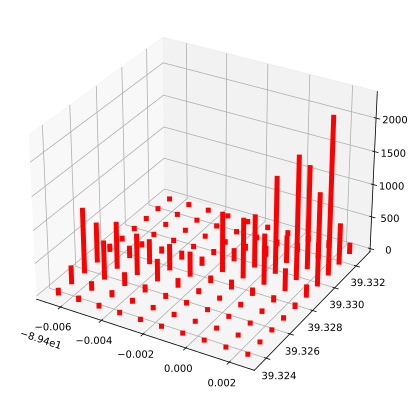

In [71]:
from mpl_toolkits import mplot3d
import numpy as np
import matplotlib.pyplot as plt

x_, y_, z_ = [el.x for el in summary_df.geometry], \
             [el.y for el in summary_df.geometry], \
              summary_df.kwh_delta.tolist()

fig = plt.figure(figsize = (10, 7))
ax = plt.axes(projection ="3d")

for el_x, el_y, el_z in zip(x_, y_, z_):
    ax.plot3D([el_x, el_x], [el_y, el_y], [0, el_z], 'red', linewidth=5.0)

plt.show()

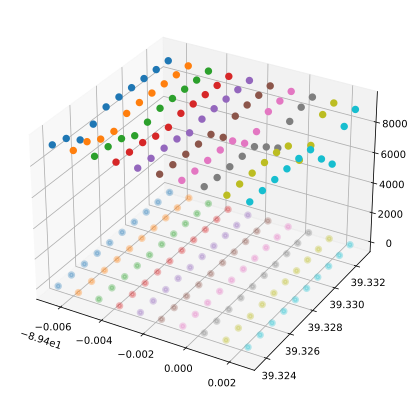

In [73]:
from mpl_toolkits import mplot3d
import numpy as np
import matplotlib.pyplot as plt

x_, y_, z_ = [el.x for el in summary_df.geometry], \
             [el.y for el in summary_df.geometry], \
              summary_df.khw_with_lom.tolist()

fig = plt.figure(figsize = (10, 7))
ax = plt.axes(projection ="3d")

for el_x, el_y, el_z in zip(x_, y_, z_):
    ax.scatter3D([el_x, el_x], [el_y, el_y], [0, el_z], 'blue', linewidth=3.0)

plt.show()

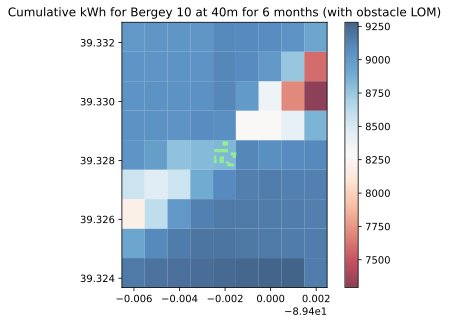

In [124]:
# following code is based on example from: https://stackoverflow.com/questions/33282368/plotting-a-2d-heatmap

import matplotlib.pyplot as plt
import numpy as np

x_, y_, z_ = [el.x for el in summary_df.geometry], \
             [el.y for el in summary_df.geometry], \
              summary_df.khw_with_lom.tolist()

# generate 2 2d grids for the x & y bounds
y, x = np.array(y_).reshape(10,-1), np.array(x_).reshape(10,-1)

z = np.array(z_).reshape(10,-1)
# x and y are bounds, so z should be the value *inside* those bounds.
# Therefore, remove the last value from the z array.
z = z[:-1, :-1]
z_min, z_max = np.abs(z).min(), np.abs(z).max()

fig, ax = plt.subplots()

c = ax.pcolormesh(x, y, z, cmap='RdBu', vmin=z_min, vmax=z_max, alpha=0.75)
ax.set_title('Cumulative kWh for Bergey 10 at 40m for 6 months (with obstacle LOM)')
# set the limits of the plot to the limits of the data
ax.axis([x.min(), x.max(), y.min(), y.max()])
fig.colorbar(c, ax=ax)

df_places.geometry.plot(color='lightgreen', ax=ax)

plt.show()

In [126]:
(np.abs(z).max() - np.abs(z).min()) / np.abs(z).max() * 100

21.43365795417006

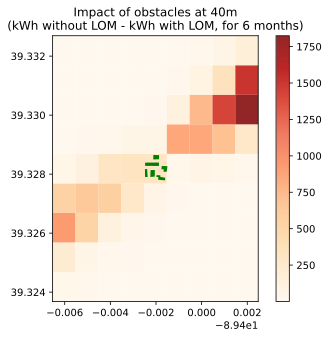

In [121]:
# following code is based on example from: https://stackoverflow.com/questions/33282368/plotting-a-2d-heatmap

import matplotlib.pyplot as plt
import numpy as np

x_, y_, z_ = [el.x for el in summary_df.geometry], \
             [el.y for el in summary_df.geometry], \
              summary_df.kwh_delta.tolist()

# generate 2 2d grids for the x & y bounds
y, x = np.array(y_).reshape(10,-1), np.array(x_).reshape(10,-1)

z = np.array(z_).reshape(10,-1)
# x and y are bounds, so z should be the value *inside* those bounds.
# Therefore, remove the last value from the z array.
z = z[:-1, :-1]
z_min, z_max = np.abs(z).min(), np.abs(z).max()

fig, ax = plt.subplots()

c = ax.pcolormesh(x, y, z, cmap='OrRd', vmin=z_min, vmax=z_max, alpha=0.85)
ax.set_title('Impact of obstacles at 40m\n(kWh without LOM - kWh with LOM, for 6 months)')
# set the limits of the plot to the limits of the data
ax.axis([x.min(), x.max(), y.min(), y.max()])
fig.colorbar(c, ax=ax)

df_places.geometry.plot(color='green', ax=ax)

plt.show()

In [127]:
summary_df

,geometry,time_period,khw_without_lom,khw_with_lom,kwh_delta,ts_file_path
0,POINT (-89.40652951922961 39.32368248594488),2007-01-01 00:00:00 - 2007-07-02 12:00:00,9211.009851,9169.033153,41.976699,../output/heatmap-180/39.32368248594488_-89.40...
1,POINT (-89.40552851822861 39.32368248594488),2007-01-01 00:00:00 - 2007-07-02 12:00:00,9217.581277,9195.320340,22.260937,../output/heatmap-180/39.32368248594488_-89.40...
2,POINT (-89.40452751722761 39.32368248594488),2007-01-01 00:00:00 - 2007-07-02 12:00:00,9224.253996,9211.449644,12.804352,../output/heatmap-180/39.32368248594488_-89.40...
3,POINT (-89.40352651622661 39.32368248594488),2007-01-01 00:00:00 - 2007-07-02 12:00:00,9239.326689,9232.843012,6.483677,../output/heatmap-180/39.32368248594488_-89.40...
4,POINT (-89.40252551522561 39.32368248594488),2007-01-01 00:00:00 - 2007-07-02 12:00:00,9251.504556,9247.585865,3.918691,../output/heatmap-180/39.32368248594488_-89.40...
...,...,...,...,...,...,...
95,POINT (-89.40152451422459 39.33269149495388),2007-01-01 00:00:00 - 2007-07-02 12:00:00,9090.465671,9083.761421,6.704250,../output/heatmap-180/39.332691494953885_-89.4...
96,POINT (-89.40052351322359 39.33269149495388),2007-01-01 00:00:00 - 2007-07-02 12:00:00,9089.812921,9077.452834,12.360087,../output/heatmap-180/39.332691494953885_-89.4...
97,POINT (-89.39952251222259 39.33269149495388),2007-01-01 00:00:00 - 2007-07-02 12:00:00,9089.205065,9066.187296,23.017770,../output/heatmap-180/39.332691494953885_-89.3...
98,POINT (-89.39852151122159 39.33269149495388),2007-01-01 00:00:00 - 2007-07-02 12:00:00,9088.673428,9042.503592,46.169836,../output/heatmap-180/39.332691494953885_-89.3...


In [128]:
ts_df

,datetime,ws,wd,ws-adjusted,kw_ts_without_lom,kw_ts_with_lom
0,2007-01-01 00:00:00,7.785012,233.034954,7.740231,3.291859,3.233544
1,2007-01-01 01:00:00,8.297718,238.696513,8.250855,3.999197,3.933337
2,2007-01-01 02:00:00,7.203153,231.841675,7.161604,2.622774,2.577415
3,2007-01-01 03:00:00,8.337746,236.997656,8.290358,4.087871,4.021089
4,2007-01-01 04:00:00,8.637312,238.298787,8.588455,4.541054,4.466161
...,...,...,...,...,...,...
4376,2007-07-02 08:00:00,6.459177,91.566366,6.459177,1.860805,1.860805
4377,2007-07-02 09:00:00,6.591325,91.791790,6.591325,1.982253,1.982253
4378,2007-07-02 10:00:00,6.412947,97.639996,6.412947,1.829223,1.829223
4379,2007-07-02 11:00:00,6.686869,102.191243,6.686869,2.076989,2.076989


In [131]:
summary_df.iloc[50].ts_file_path

'../output/heatmap-180/39.32868749094988_-89.40652951922961.csv'

In [132]:
ts_df_for_middle = pd.read_csv('../output/heatmap-180/39.32868749094988_-89.40652951922961.csv')

In [133]:
ts_df_for_middle

,datetime,ws,wd,ws-adjusted,kw_ts_without_lom,kw_ts_with_lom
0,2007-01-01 00:00:00,7.664650,231.612594,7.664650,3.135464,3.135464
1,2007-01-01 01:00:00,8.189462,238.231211,8.189462,3.847463,3.847463
2,2007-01-01 02:00:00,7.134345,232.281767,7.134345,2.547986,2.547986
3,2007-01-01 03:00:00,8.311078,237.648856,8.311078,4.050688,4.050688
4,2007-01-01 04:00:00,8.564693,237.837481,8.564693,4.430197,4.430197
...,...,...,...,...,...,...
4376,2007-07-02 08:00:00,6.461884,90.337806,6.454384,1.863267,1.856896
4377,2007-07-02 09:00:00,6.561321,90.668206,6.553680,1.954710,1.947651
4378,2007-07-02 10:00:00,6.346073,96.557849,6.338238,1.772506,1.765841
4379,2007-07-02 11:00:00,6.651165,100.878888,6.642653,2.044151,2.036279
